# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [5]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [6]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [7]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def centroid_undersampling(data):
    '''Faz o undersampling pegando as amostras do centro do cluster
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    centrounder = ClusterCentroids(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = centrounder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = centrounder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [8]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [9]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = centroid_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [10]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 126, 1.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [12]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [13]:
learnRate = 0.001
graficoName = "centroid-0.001-"

## RNA 1 (3)

In [17]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso
early_stopping = EarlyStopping(monitor='val_loss', patience=50) #para que não corra o risco de decorar os dados
history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping], validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 1s - loss: 0.5878 - acc: 0.5040 - val_loss: 0.9502 - val_acc: 0.4921
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5712 - acc: 0.5079 - val_loss: 0.9298 - val_acc: 0.5000
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5556 - acc: 0.5079 - val_loss: 0.9106 - val_acc: 0.5000
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5423 - acc: 0.5119 - val_loss: 0.8920 - val_acc: 0.5000
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5267 - acc: 0.5119 - val_loss: 0.8739 - val_acc: 0.5000
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5124 - acc: 0.5238 - val_loss: 0.8564 - val_acc: 0.5079
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4992 - acc: 0.5198 - val_loss: 0.8397 - val_acc: 0.5079
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4867 - acc

252/252 [==============================] - 0s - loss: 0.2098 - acc: 0.7183 - val_loss: 0.4308 - val_acc: 0.6825
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.2084 - acc: 0.7183 - val_loss: 0.4282 - val_acc: 0.6905
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.2072 - acc: 0.7222 - val_loss: 0.4255 - val_acc: 0.6905
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.2059 - acc: 0.7222 - val_loss: 0.4230 - val_acc: 0.6984
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.2048 - acc: 0.7262 - val_loss: 0.4203 - val_acc: 0.6984
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.2036 - acc: 0.7302 - val_loss: 0.4178 - val_acc: 0.6984
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.2025 - acc: 0.7341 - val_loss: 0.4153 - val_acc: 0.6984
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.2014 - acc: 0.7341 - val_loss: 0.4129 - val_acc: 0.7063
Epoch 

252/252 [==============================] - 0s - loss: 0.1678 - acc: 0.7897 - val_loss: 0.3204 - val_acc: 0.7778
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1675 - acc: 0.7897 - val_loss: 0.3192 - val_acc: 0.7778
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1672 - acc: 0.7897 - val_loss: 0.3180 - val_acc: 0.7778
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1668 - acc: 0.7897 - val_loss: 0.3170 - val_acc: 0.7778
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1665 - acc: 0.7897 - val_loss: 0.3158 - val_acc: 0.7778
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1661 - acc: 0.7897 - val_loss: 0.3147 - val_acc: 0.7778
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1659 - acc: 0.7897 - val_loss: 0.3136 - val_acc: 0.7778
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1656 - acc: 0.7897 - val_loss: 0.3127 - val_acc: 0.7778

252/252 [==============================] - 0s - loss: 0.1529 - acc: 0.8135 - val_loss: 0.2682 - val_acc: 0.7857
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.1527 - acc: 0.8135 - val_loss: 0.2676 - val_acc: 0.7857
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.1526 - acc: 0.8135 - val_loss: 0.2671 - val_acc: 0.7857
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.1524 - acc: 0.8135 - val_loss: 0.2666 - val_acc: 0.7857
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.1523 - acc: 0.8135 - val_loss: 0.2661 - val_acc: 0.7857
Epoch 198/2000
252/252 [==============================] - ETA: 0s - loss: 0.1715 - acc: 0.750 - 0s - loss: 0.1521 - acc: 0.8095 - val_loss: 0.2655 - val_acc: 0.7857
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.1520 - acc: 0.8135 - val_loss: 0.2650 - val_acc: 0.7778
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.1518 - acc: 0.809

252/252 [==============================] - 0s - loss: 0.1444 - acc: 0.8333 - val_loss: 0.2408 - val_acc: 0.7857
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.1443 - acc: 0.8333 - val_loss: 0.2405 - val_acc: 0.7857
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.1442 - acc: 0.8333 - val_loss: 0.2402 - val_acc: 0.7857
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.1441 - acc: 0.8333 - val_loss: 0.2399 - val_acc: 0.7857
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.1440 - acc: 0.8333 - val_loss: 0.2395 - val_acc: 0.7857
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.1439 - acc: 0.8333 - val_loss: 0.2392 - val_acc: 0.7857
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.1437 - acc: 0.8333 - val_loss: 0.2389 - val_acc: 0.7857
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.1436 - acc: 0.8333 - val_loss: 0.2386 - val_acc: 0.7857

252/252 [==============================] - 0s - loss: 0.1380 - acc: 0.8452 - val_loss: 0.2237 - val_acc: 0.7937
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.1379 - acc: 0.8413 - val_loss: 0.2235 - val_acc: 0.7937
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.1378 - acc: 0.8452 - val_loss: 0.2233 - val_acc: 0.7937
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.1377 - acc: 0.8452 - val_loss: 0.2232 - val_acc: 0.7937
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.1377 - acc: 0.8413 - val_loss: 0.2230 - val_acc: 0.7937
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.1376 - acc: 0.8413 - val_loss: 0.2228 - val_acc: 0.7937
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.1375 - acc: 0.8413 - val_loss: 0.2226 - val_acc: 0.7937
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.1374 - acc: 0.8452 - val_loss: 0.2224 - val_acc: 0.7937

252/252 [==============================] - 0s - loss: 0.1327 - acc: 0.8611 - val_loss: 0.2125 - val_acc: 0.8095
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.1326 - acc: 0.8611 - val_loss: 0.2123 - val_acc: 0.8095
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.1325 - acc: 0.8611 - val_loss: 0.2122 - val_acc: 0.8095
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.1325 - acc: 0.8611 - val_loss: 0.2120 - val_acc: 0.8095
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.1324 - acc: 0.8611 - val_loss: 0.2119 - val_acc: 0.8095
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.1323 - acc: 0.8651 - val_loss: 0.2117 - val_acc: 0.8095
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.1322 - acc: 0.8651 - val_loss: 0.2116 - val_acc: 0.8095
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.1322 - acc: 0.8651 - val_loss: 0.2114 - val_acc: 0.8095

252/252 [==============================] - 0s - loss: 0.1284 - acc: 0.8611 - val_loss: 0.2041 - val_acc: 0.8254
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.1284 - acc: 0.8611 - val_loss: 0.2040 - val_acc: 0.8254
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.1283 - acc: 0.8611 - val_loss: 0.2039 - val_acc: 0.8254
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.1282 - acc: 0.8611 - val_loss: 0.2038 - val_acc: 0.8254
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.1282 - acc: 0.8611 - val_loss: 0.2037 - val_acc: 0.8254
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.1281 - acc: 0.8611 - val_loss: 0.2036 - val_acc: 0.8254
Epoch 455/2000
252/252 [==============================] - ETA: 0s - loss: 0.1457 - acc: 0.843 - 0s - loss: 0.1281 - acc: 0.8651 - val_loss: 0.2035 - val_acc: 0.8254
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.1280 - acc: 0.861

252/252 [==============================] - 0s - loss: 0.1249 - acc: 0.8611 - val_loss: 0.1988 - val_acc: 0.8254
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.1249 - acc: 0.8611 - val_loss: 0.1987 - val_acc: 0.8254
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.1248 - acc: 0.8611 - val_loss: 0.1986 - val_acc: 0.8254
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.1248 - acc: 0.8611 - val_loss: 0.1986 - val_acc: 0.8254
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.1248 - acc: 0.8611 - val_loss: 0.1985 - val_acc: 0.8254
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.1247 - acc: 0.8611 - val_loss: 0.1984 - val_acc: 0.8254
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.1246 - acc: 0.8611 - val_loss: 0.1984 - val_acc: 0.8254
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.1246 - acc: 0.8611 - val_loss: 0.1983 - val_acc: 0.8254

252/252 [==============================] - 0s - loss: 0.1220 - acc: 0.8690 - val_loss: 0.1948 - val_acc: 0.8413
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.1220 - acc: 0.8690 - val_loss: 0.1947 - val_acc: 0.8413
Epoch 579/2000
252/252 [==============================] - ETA: 0s - loss: 0.1066 - acc: 0.843 - 0s - loss: 0.1220 - acc: 0.8690 - val_loss: 0.1946 - val_acc: 0.8413
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.1219 - acc: 0.8690 - val_loss: 0.1946 - val_acc: 0.8413
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.1219 - acc: 0.8690 - val_loss: 0.1946 - val_acc: 0.8413
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.1219 - acc: 0.8690 - val_loss: 0.1945 - val_acc: 0.8413
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.1218 - acc: 0.8690 - val_loss: 0.1945 - val_acc: 0.8413
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.1218 - acc: 0.869

252/252 [==============================] - 0s - loss: 0.1193 - acc: 0.8690 - val_loss: 0.1957 - val_acc: 0.8413
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.1192 - acc: 0.8690 - val_loss: 0.1958 - val_acc: 0.8413
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.1192 - acc: 0.8690 - val_loss: 0.1958 - val_acc: 0.8413
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.1192 - acc: 0.8690 - val_loss: 0.1959 - val_acc: 0.8413
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.1191 - acc: 0.8730 - val_loss: 0.1959 - val_acc: 0.8413
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.1191 - acc: 0.8690 - val_loss: 0.1960 - val_acc: 0.8413
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.1190 - acc: 0.8730 - val_loss: 0.1960 - val_acc: 0.8413
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.1190 - acc: 0.8730 - val_loss: 0.1960 - val_acc: 0.8413

In [15]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1088/1962 [===============>..............] - ETA: 0s[0.075442036387874209, 0.91590214067278286]


<IPython.core.display.Javascript object>


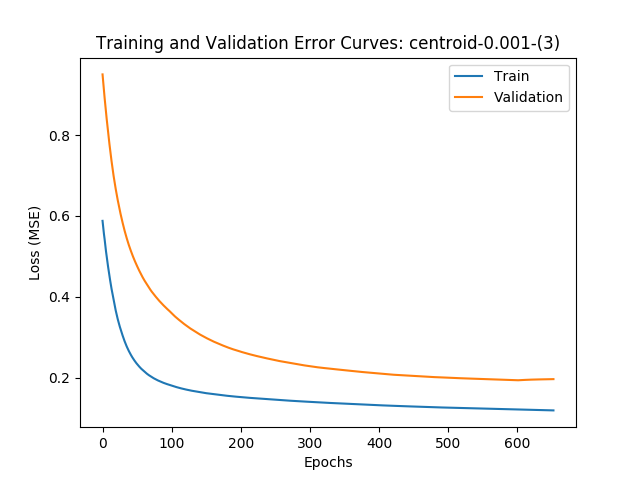

<IPython.core.display.Javascript object>


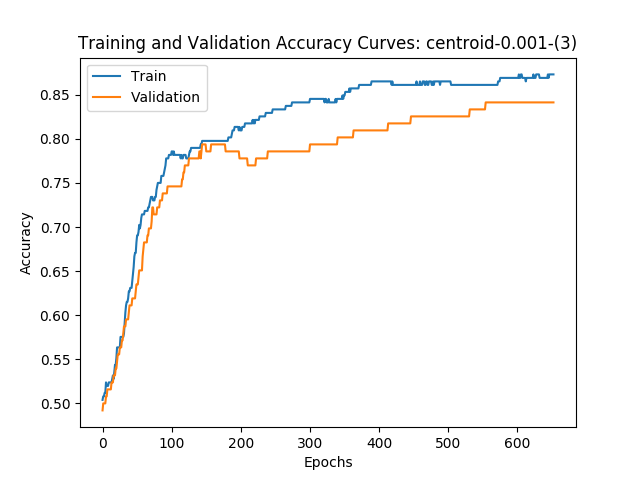

Matriz de confusão
[[1702  196]
 [   8   56]]

Train Loss:       0.1210
Validation Loss:  0.1934
Accuracy:         0.8960
MSE:              0.1040
AUROC:            0.9371


In [18]:
plot_training_error_curves(history, graficoName + "(3)")
plot_training_acc_curves(history, graficoName + "(3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (5)

In [23]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
early_stopping = EarlyStopping(monitor='val_loss', patience=100) 
adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.6566 - acc: 0.3016 - val_loss: 0.5940 - val_acc: 0.3333
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.6062 - acc: 0.3373 - val_loss: 0.5537 - val_acc: 0.3810
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5658 - acc: 0.3730 - val_loss: 0.5215 - val_acc: 0.4206
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5359 - acc: 0.4087 - val_loss: 0.4952 - val_acc: 0.4444
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5134 - acc: 0.4246 - val_loss: 0.4734 - val_acc: 0.4762
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4939 - acc: 0.4563 - val_loss: 0.4519 - val_acc: 0.4921
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4757 - acc: 0.4960 - val_loss: 0.4316 - val_acc: 0.4921
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4589 - acc

252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8810 - val_loss: 0.1052 - val_acc: 0.8810
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.8810 - val_loss: 0.1049 - val_acc: 0.8810
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.8810 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8849 - val_loss: 0.1026 - val_acc: 0.8810
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.8849 - val_loss: 0.1016 - val_acc: 0.8810
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.8849 - val_loss: 0.1023 - val_acc: 0.8810
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.8849 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.8849 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 

252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.8929 - val_loss: 0.0933 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.8929 - val_loss: 0.0921 - val_acc: 0.8810
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.8929 - val_loss: 0.0915 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.8929 - val_loss: 0.0926 - val_acc: 0.8810
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.8929 - val_loss: 0.0917 - val_acc: 0.8810
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.8889 - val_loss: 0.0912 - val_acc: 0.8730
Epoch 135/2000
252/252 [==============================] - ETA: 0s - loss: 0.0949 - acc: 0.875 - 0s - loss: 0.0730 - acc: 0.8929 - val_loss: 0.0915 - val_acc: 0.8810
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.892

252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9048 - val_loss: 0.0830 - val_acc: 0.8889
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.8968 - val_loss: 0.0844 - val_acc: 0.8810
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.8968 - val_loss: 0.0843 - val_acc: 0.8810
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.8968 - val_loss: 0.0838 - val_acc: 0.8810
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9048 - val_loss: 0.0829 - val_acc: 0.8810
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9048 - val_loss: 0.0836 - val_acc: 0.8730
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9048 - val_loss: 0.0836 - val_acc: 0.8889
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9008 - val_loss: 0.0831 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9127 - val_loss: 0.0782 - val_acc: 0.8730
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9087 - val_loss: 0.0781 - val_acc: 0.8810
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9087 - val_loss: 0.0774 - val_acc: 0.8889
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9087 - val_loss: 0.0778 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - ETA: 0s - loss: 0.1071 - acc: 0.781 - 0s - loss: 0.0627 - acc: 0.9127 - val_loss: 0.0781 - val_acc: 0.8810
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9087 - val_loss: 0.0777 - val_acc: 0.8730
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9087 - val_loss: 0.0776 - val_acc: 0.8889
Epoch 264/2000
252/252 [==============================] - ETA: 0s - loss: 0.0114 - acc: 

252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9167 - val_loss: 0.0752 - val_acc: 0.8968
Epoch 321/2000
252/252 [==============================] - 0s - loss: 0.0595 - acc: 0.9167 - val_loss: 0.0746 - val_acc: 0.8968
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0595 - acc: 0.9206 - val_loss: 0.0747 - val_acc: 0.8968
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9206 - val_loss: 0.0747 - val_acc: 0.8968
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9167 - val_loss: 0.0751 - val_acc: 0.8968
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0595 - acc: 0.9167 - val_loss: 0.0749 - val_acc: 0.8968
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0595 - acc: 0.9167 - val_loss: 0.0749 - val_acc: 0.8968
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9167 - val_loss: 0.0747 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9246 - val_loss: 0.0725 - val_acc: 0.8968
Epoch 385/2000
252/252 [==============================] - 0s - loss: 0.0572 - acc: 0.9246 - val_loss: 0.0718 - val_acc: 0.9048
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9246 - val_loss: 0.0717 - val_acc: 0.9048
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9246 - val_loss: 0.0717 - val_acc: 0.8968
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9246 - val_loss: 0.0718 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9246 - val_loss: 0.0724 - val_acc: 0.8968
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9246 - val_loss: 0.0714 - val_acc: 0.9048
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9246 - val_loss: 0.0717 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9246 - val_loss: 0.0692 - val_acc: 0.9127
Epoch 449/2000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9246 - val_loss: 0.0695 - val_acc: 0.9048
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9246 - val_loss: 0.0688 - val_acc: 0.9048
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9246 - val_loss: 0.0689 - val_acc: 0.9127
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9286 - val_loss: 0.0705 - val_acc: 0.9127
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0549 - acc: 0.9246 - val_loss: 0.0696 - val_acc: 0.9127
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9246 - val_loss: 0.0683 - val_acc: 0.9127
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9246 - val_loss: 0.0690 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0533 - acc: 0.9286 - val_loss: 0.0685 - val_acc: 0.9127
Epoch 513/2000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9286 - val_loss: 0.0684 - val_acc: 0.9127
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0533 - acc: 0.9286 - val_loss: 0.0685 - val_acc: 0.9127
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9286 - val_loss: 0.0684 - val_acc: 0.9127
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0532 - acc: 0.9286 - val_loss: 0.0678 - val_acc: 0.9127
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0533 - acc: 0.9325 - val_loss: 0.0686 - val_acc: 0.9127
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0532 - acc: 0.9286 - val_loss: 0.0680 - val_acc: 0.9127
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0532 - acc: 0.9286 - val_loss: 0.0680 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0519 - acc: 0.9325 - val_loss: 0.0682 - val_acc: 0.9127
Epoch 577/2000
252/252 [==============================] - 0s - loss: 0.0518 - acc: 0.9325 - val_loss: 0.0678 - val_acc: 0.9127
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9325 - val_loss: 0.0676 - val_acc: 0.9127
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9325 - val_loss: 0.0667 - val_acc: 0.9127
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9325 - val_loss: 0.0676 - val_acc: 0.9127
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9325 - val_loss: 0.0679 - val_acc: 0.9127
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0522 - acc: 0.9325 - val_loss: 0.0674 - val_acc: 0.9127
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0518 - acc: 0.9325 - val_loss: 0.0687 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9325 - val_loss: 0.0673 - val_acc: 0.9048
Epoch 641/2000
252/252 [==============================] - 0s - loss: 0.0508 - acc: 0.9325 - val_loss: 0.0666 - val_acc: 0.9048
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9325 - val_loss: 0.0671 - val_acc: 0.9127
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9325 - val_loss: 0.0670 - val_acc: 0.9127
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0508 - acc: 0.9325 - val_loss: 0.0685 - val_acc: 0.9048
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0508 - acc: 0.9325 - val_loss: 0.0664 - val_acc: 0.9048
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9325 - val_loss: 0.0673 - val_acc: 0.9048
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9325 - val_loss: 0.0676 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9325 - val_loss: 0.0670 - val_acc: 0.9048
Epoch 705/2000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9325 - val_loss: 0.0673 - val_acc: 0.9048
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9325 - val_loss: 0.0678 - val_acc: 0.9127
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9325 - val_loss: 0.0666 - val_acc: 0.9048
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9325 - val_loss: 0.0688 - val_acc: 0.9048
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9325 - val_loss: 0.0669 - val_acc: 0.9048
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9325 - val_loss: 0.0672 - val_acc: 0.9048
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0496 - acc: 0.9325 - val_loss: 0.0664 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9365 - val_loss: 0.0680 - val_acc: 0.9127
Epoch 769/2000
252/252 [==============================] - 0s - loss: 0.0483 - acc: 0.9365 - val_loss: 0.0670 - val_acc: 0.9127
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9365 - val_loss: 0.0684 - val_acc: 0.9127
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0485 - acc: 0.9365 - val_loss: 0.0672 - val_acc: 0.9048
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9365 - val_loss: 0.0666 - val_acc: 0.9127
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0480 - acc: 0.9365 - val_loss: 0.0672 - val_acc: 0.9127
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9365 - val_loss: 0.0678 - val_acc: 0.9048
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9365 - val_loss: 0.0677 - val_acc: 0.9127

252/252 [==============================] - ETA: 0s - loss: 0.0239 - acc: 0.968 - 0s - loss: 0.0474 - acc: 0.9405 - val_loss: 0.0682 - val_acc: 0.9127
Epoch 833/2000
252/252 [==============================] - 0s - loss: 0.0467 - acc: 0.9405 - val_loss: 0.0673 - val_acc: 0.9127
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0469 - acc: 0.9405 - val_loss: 0.0690 - val_acc: 0.9127
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0469 - acc: 0.9405 - val_loss: 0.0675 - val_acc: 0.9127
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0469 - acc: 0.9405 - val_loss: 0.0679 - val_acc: 0.9127
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9405 - val_loss: 0.0677 - val_acc: 0.9127
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0467 - acc: 0.9405 - val_loss: 0.0675 - val_acc: 0.9127
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0467 - acc: 0.940

In [27]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.089438397448726392, 0.87869520903119736]


<IPython.core.display.Javascript object>


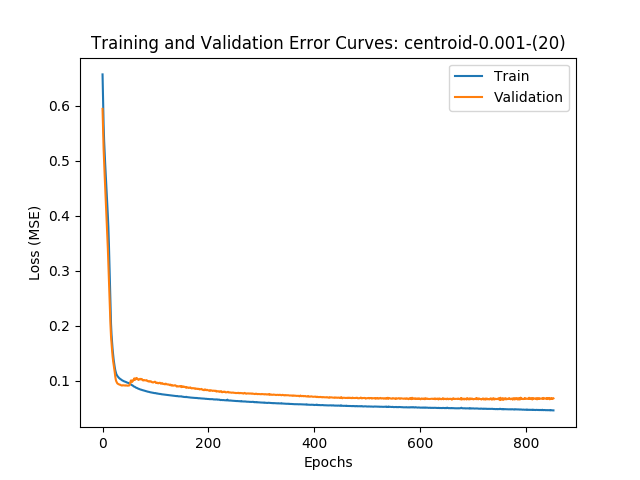

<IPython.core.display.Javascript object>


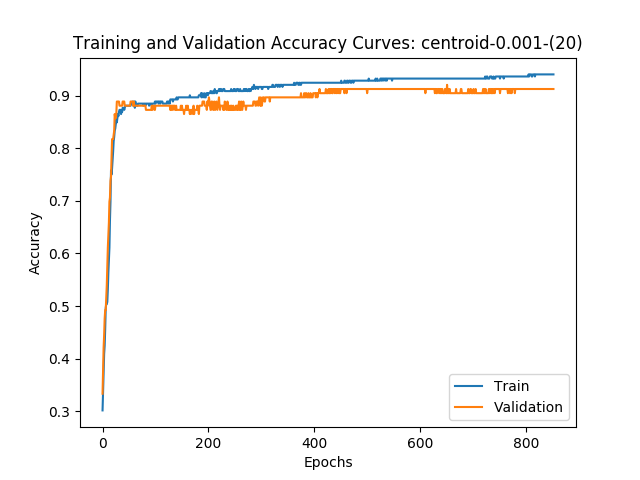

Matriz de confusão
[[1761  137]
 [   8   56]]

Train Loss:       0.0493
Validation Loss:  0.0650
Accuracy:         0.9261
MSE:              0.0739
AUROC:            0.9501


In [24]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [30]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

early_stopping = EarlyStopping(monitor='val_loss', patience=300) 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

In [31]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1440/1962 [=====================>........] - ETA: 0s[0.072291966765989896, 0.89857288481141695]


<IPython.core.display.Javascript object>


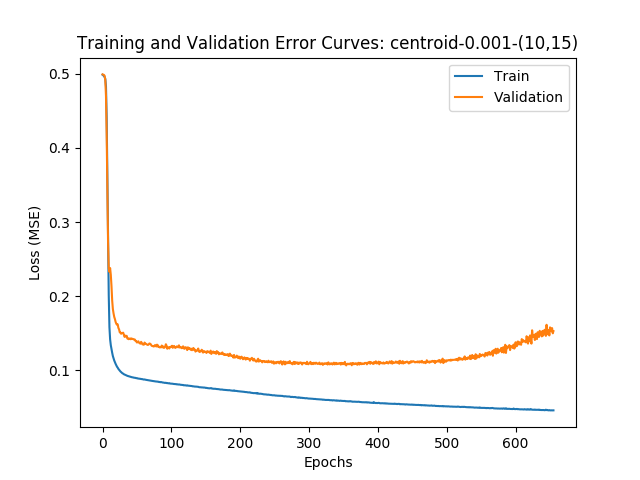

<IPython.core.display.Javascript object>


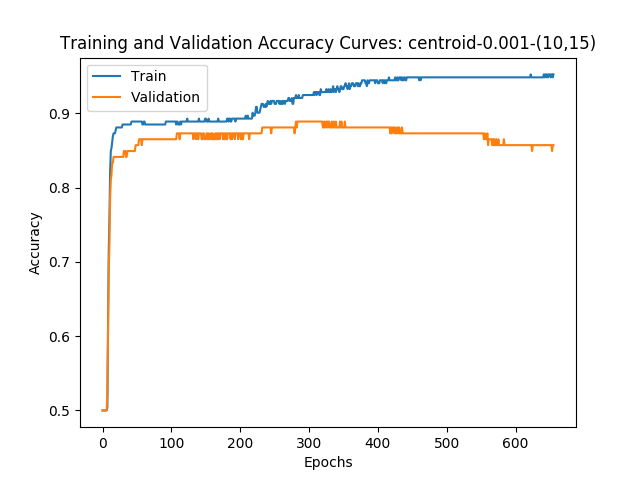

Matriz de confusão
[[1710  188]
 [  10   54]]

Train Loss:       0.0580
Validation Loss:  0.1064
Accuracy:         0.8991
MSE:              0.1009
AUROC:            0.9297


In [32]:
plot_training_error_curves(history, graficoName + "(10,15)")
plot_training_acc_curves(history, graficoName + "(10,15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (5,3)

In [37]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 3s - loss: 0.4872 - acc: 0.5000 - val_loss: 0.4648 - val_acc: 0.5000
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4416 - acc: 0.5000 - val_loss: 0.4132 - val_acc: 0.5000
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.3851 - acc: 0.5000 - val_loss: 0.3533 - val_acc: 0.5079
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.3233 - acc: 0.5238 - val_loss: 0.2975 - val_acc: 0.5238
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.2721 - acc: 0.5794 - val_loss: 0.2535 - val_acc: 0.5794
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.2315 - acc: 0.6429 - val_loss: 0.2162 - val_acc: 0.6587
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1978 - acc: 0.6984 - val_loss: 0.1876 - val_acc: 0.6984
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1731 - acc

/home/milena/enviroments/my_env/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101873). Check your callbacks.
  % delta_t_median)


252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9127 - val_loss: 0.0991 - val_acc: 0.8651
Epoch 55/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9127 - val_loss: 0.0982 - val_acc: 0.8730
Epoch 56/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9127 - val_loss: 0.0985 - val_acc: 0.8651
Epoch 57/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9127 - val_loss: 0.0974 - val_acc: 0.8651
Epoch 58/2000
252/252 [==============================] - ETA: 0s - loss: 0.0615 - acc: 0.906 - 0s - loss: 0.0700 - acc: 0.9087 - val_loss: 0.0968 - val_acc: 0.8651
Epoch 59/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9127 - val_loss: 0.0967 - val_acc: 0.8651
Epoch 60/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0965 - val_acc: 0.8651
Epoch 61/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9127 - val

252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9325 - val_loss: 0.0754 - val_acc: 0.8889
Epoch 119/2000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9325 - val_loss: 0.0761 - val_acc: 0.8810
Epoch 120/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9325 - val_loss: 0.0758 - val_acc: 0.8810
Epoch 121/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9246 - val_loss: 0.0748 - val_acc: 0.8810
Epoch 122/2000
252/252 [==============================] - 0s - loss: 0.0539 - acc: 0.9286 - val_loss: 0.0753 - val_acc: 0.8889
Epoch 123/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9325 - val_loss: 0.0758 - val_acc: 0.8889
Epoch 124/2000
252/252 [==============================] - 0s - loss: 0.0539 - acc: 0.9286 - val_loss: 0.0745 - val_acc: 0.8889
Epoch 125/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9325 - val_loss: 0.0751 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0465 - acc: 0.9405 - val_loss: 0.0689 - val_acc: 0.9127
Epoch 182/2000
252/252 [==============================] - ETA: 0s - loss: 0.0382 - acc: 0.906 - 0s - loss: 0.0457 - acc: 0.9405 - val_loss: 0.0694 - val_acc: 0.9127
Epoch 183/2000
252/252 [==============================] - 0s - loss: 0.0458 - acc: 0.9365 - val_loss: 0.0692 - val_acc: 0.9048
Epoch 184/2000
252/252 [==============================] - 0s - loss: 0.0459 - acc: 0.9365 - val_loss: 0.0687 - val_acc: 0.9048
Epoch 185/2000
252/252 [==============================] - 0s - loss: 0.0453 - acc: 0.9365 - val_loss: 0.0691 - val_acc: 0.9048
Epoch 186/2000
252/252 [==============================] - 0s - loss: 0.0452 - acc: 0.9365 - val_loss: 0.0683 - val_acc: 0.9127
Epoch 187/2000
252/252 [==============================] - 0s - loss: 0.0452 - acc: 0.9405 - val_loss: 0.0674 - val_acc: 0.9127
Epoch 188/2000
252/252 [==============================] - 0s - loss: 0.0452 - acc: 0.940

252/252 [==============================] - 0s - loss: 0.0399 - acc: 0.9484 - val_loss: 0.0680 - val_acc: 0.9048
Epoch 245/2000
252/252 [==============================] - 0s - loss: 0.0398 - acc: 0.9444 - val_loss: 0.0681 - val_acc: 0.9048
Epoch 246/2000
252/252 [==============================] - ETA: 0s - loss: 0.0664 - acc: 0.906 - 0s - loss: 0.0402 - acc: 0.9444 - val_loss: 0.0684 - val_acc: 0.9127
Epoch 247/2000
252/252 [==============================] - 0s - loss: 0.0397 - acc: 0.9484 - val_loss: 0.0701 - val_acc: 0.9048
Epoch 248/2000
252/252 [==============================] - 0s - loss: 0.0399 - acc: 0.9484 - val_loss: 0.0680 - val_acc: 0.9048
Epoch 249/2000
252/252 [==============================] - 0s - loss: 0.0396 - acc: 0.9484 - val_loss: 0.0686 - val_acc: 0.9048
Epoch 250/2000
252/252 [==============================] - 0s - loss: 0.0400 - acc: 0.9444 - val_loss: 0.0710 - val_acc: 0.9048
Epoch 251/2000
252/252 [==============================] - 0s - loss: 0.0398 - acc: 0.948

252/252 [==============================] - 0s - loss: 0.0366 - acc: 0.9524 - val_loss: 0.0749 - val_acc: 0.9048
Epoch 309/2000
252/252 [==============================] - 0s - loss: 0.0351 - acc: 0.9524 - val_loss: 0.0726 - val_acc: 0.9048
Epoch 310/2000
252/252 [==============================] - 0s - loss: 0.0358 - acc: 0.9563 - val_loss: 0.0724 - val_acc: 0.9048
Epoch 311/2000
252/252 [==============================] - 0s - loss: 0.0355 - acc: 0.9563 - val_loss: 0.0745 - val_acc: 0.9048
Epoch 312/2000
252/252 [==============================] - 0s - loss: 0.0354 - acc: 0.9524 - val_loss: 0.0722 - val_acc: 0.9048
Epoch 313/2000
252/252 [==============================] - 0s - loss: 0.0356 - acc: 0.9563 - val_loss: 0.0729 - val_acc: 0.9048
Epoch 314/2000
252/252 [==============================] - 0s - loss: 0.0355 - acc: 0.9603 - val_loss: 0.0763 - val_acc: 0.9048
Epoch 315/2000
252/252 [==============================] - 0s - loss: 0.0352 - acc: 0.9524 - val_loss: 0.0741 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0328 - acc: 0.9603 - val_loss: 0.0748 - val_acc: 0.9048
Epoch 373/2000
252/252 [==============================] - 0s - loss: 0.0321 - acc: 0.9643 - val_loss: 0.0756 - val_acc: 0.9127
Epoch 374/2000
252/252 [==============================] - 0s - loss: 0.0324 - acc: 0.9603 - val_loss: 0.0745 - val_acc: 0.9048
Epoch 375/2000
252/252 [==============================] - 0s - loss: 0.0327 - acc: 0.9643 - val_loss: 0.0748 - val_acc: 0.9048
Epoch 376/2000
252/252 [==============================] - 0s - loss: 0.0328 - acc: 0.9643 - val_loss: 0.0772 - val_acc: 0.9048
Epoch 377/2000
252/252 [==============================] - 0s - loss: 0.0319 - acc: 0.9643 - val_loss: 0.0739 - val_acc: 0.9048
Epoch 378/2000
252/252 [==============================] - 0s - loss: 0.0322 - acc: 0.9643 - val_loss: 0.0760 - val_acc: 0.9048
Epoch 379/2000
252/252 [==============================] - 0s - loss: 0.0328 - acc: 0.9643 - val_loss: 0.0763 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9683 - val_loss: 0.0794 - val_acc: 0.9127
Epoch 437/2000
252/252 [==============================] - 0s - loss: 0.0303 - acc: 0.9683 - val_loss: 0.0778 - val_acc: 0.9048
Epoch 438/2000
252/252 [==============================] - 0s - loss: 0.0298 - acc: 0.9683 - val_loss: 0.0787 - val_acc: 0.9127
Epoch 439/2000
252/252 [==============================] - 0s - loss: 0.0302 - acc: 0.9722 - val_loss: 0.0788 - val_acc: 0.9127
Epoch 440/2000
252/252 [==============================] - 0s - loss: 0.0305 - acc: 0.9683 - val_loss: 0.0792 - val_acc: 0.9048
Epoch 441/2000
252/252 [==============================] - 0s - loss: 0.0300 - acc: 0.9683 - val_loss: 0.0798 - val_acc: 0.9127
Epoch 442/2000
252/252 [==============================] - 0s - loss: 0.0296 - acc: 0.9722 - val_loss: 0.0779 - val_acc: 0.9127
Epoch 443/2000
252/252 [==============================] - 0s - loss: 0.0297 - acc: 0.9683 - val_loss: 0.0790 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0284 - acc: 0.9683 - val_loss: 0.0799 - val_acc: 0.9127
Epoch 501/2000
252/252 [==============================] - 0s - loss: 0.0286 - acc: 0.9722 - val_loss: 0.0780 - val_acc: 0.9127
Epoch 502/2000
252/252 [==============================] - 0s - loss: 0.0295 - acc: 0.9683 - val_loss: 0.0802 - val_acc: 0.9127
Epoch 503/2000
252/252 [==============================] - 0s - loss: 0.0278 - acc: 0.9683 - val_loss: 0.0781 - val_acc: 0.9127
Epoch 504/2000
252/252 [==============================] - 0s - loss: 0.0280 - acc: 0.9683 - val_loss: 0.0810 - val_acc: 0.9127
Epoch 505/2000
252/252 [==============================] - 0s - loss: 0.0286 - acc: 0.9683 - val_loss: 0.0803 - val_acc: 0.9127
Epoch 506/2000
252/252 [==============================] - 0s - loss: 0.0280 - acc: 0.9683 - val_loss: 0.0802 - val_acc: 0.9127
Epoch 507/2000
252/252 [==============================] - 0s - loss: 0.0283 - acc: 0.9683 - val_loss: 0.0781 - val_acc: 0.9127

In [36]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.082341598458853943, 0.87155963308828199]


<IPython.core.display.Javascript object>


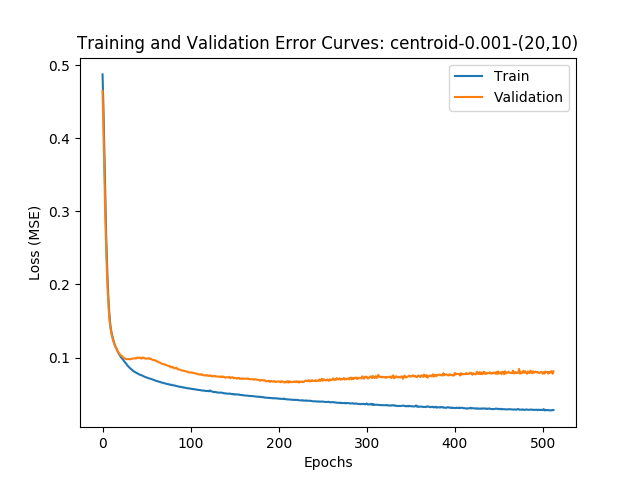

<IPython.core.display.Javascript object>


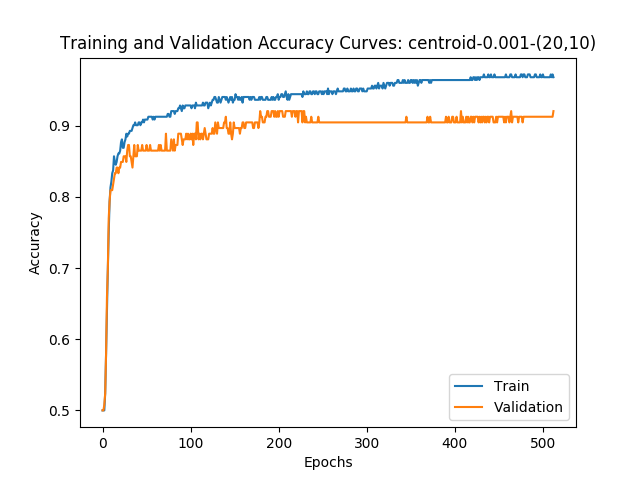

Matriz de confusão
[[1703  195]
 [   8   56]]

Train Loss:       0.0427
Validation Loss:  0.0658
Accuracy:         0.8965
MSE:              0.1035
AUROC:            0.9244


In [38]:
plot_training_error_curves(history, "centroid-0.001-(20,10)")
plot_training_acc_curves(history, "centroid-0.001-(20,10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [41]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4959 - acc: 0.5000 - val_loss: 0.4975 - val_acc: 0.4921
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4940 - acc: 0.5000 - val_loss: 0.4955 - val_acc: 0.4921
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4918 - acc: 0.5000 - val_loss: 0.4932 - val_acc: 0.4921
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4893 - acc: 0.5000 - val_loss: 0.4903 - val_acc: 0.4841
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4859 - acc: 0.4960 - val_loss: 0.4859 - val_acc: 0.4841
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4813 - acc: 0.4960 - val_loss: 0.4798 - val_acc: 0.4841
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4746 - acc: 0.4960 - val_loss: 0.4718 - val_acc: 0.4841
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4651 - acc

252/252 [==============================] - 0s - loss: 0.1108 - acc: 0.8929 - val_loss: 0.1806 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1105 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1101 - acc: 0.8929 - val_loss: 0.1801 - val_acc: 0.8651
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1099 - acc: 0.8929 - val_loss: 0.1801 - val_acc: 0.8651
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8929 - val_loss: 0.1804 - val_acc: 0.8651
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8929 - val_loss: 0.1803 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1093 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8968 - val_loss: 0.1683 - val_acc: 0.8730
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8968 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1688 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1692 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8968 - val_loss: 0.1688 - val_acc: 0.8730
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8968 - val_loss: 0.1685 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8968 - val_loss: 0.1683 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8849 - val_loss: 0.1601 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1607 - val_acc: 0.8730
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1606 - val_acc: 0.8730
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1605 - val_acc: 0.8730
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1606 - val_acc: 0.8730
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1608 - val_acc: 0.8730
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1607 - val_acc: 0.8730
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1610 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1584 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1589 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1587 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1594 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1595 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1598 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8968 - val_loss: 0.1601 - val_acc: 0.8730
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8968 - val_loss: 0.1600 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9048 - val_loss: 0.1589 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.9048 - val_loss: 0.1588 - val_acc: 0.8889
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.9048 - val_loss: 0.1585 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9008 - val_loss: 0.1584 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1583 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1589 - val_acc: 0.8889
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1590 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.9008 - val_loss: 0.1595 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.8968 - val_loss: 0.1537 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1538 - val_acc: 0.8889
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1538 - val_acc: 0.8889
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1528 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1525 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1533 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1534 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1529 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1481 - val_acc: 0.8889
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1473 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1470 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1470 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1475 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1477 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1475 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1477 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1423 - val_acc: 0.8889
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1419 - val_acc: 0.8889
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1411 - val_acc: 0.8889
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1411 - val_acc: 0.8889
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1409 - val_acc: 0.8889
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1407 - val_acc: 0.8889
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1414 - val_acc: 0.8889
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1412 - val_acc:

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8889
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1358 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1355 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1359 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1364 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1359 - val_acc: 0.8889
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1361 - val_acc:

252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9048 - val_loss: 0.1334 - val_acc: 0.8889
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1327 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9048 - val_loss: 0.1330 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9048 - val_loss: 0.1331 - val_acc: 0.8889
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1330 - val_acc: 0.8889
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1331 - val_acc: 0.8889
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1330 - val_acc:

252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1319 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1317 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1318 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1319 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1314 - val_acc:

252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1317 - val_acc: 0.8730
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1313 - val_acc: 0.8810
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9048 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1318 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1312 - val_acc: 0.8810
Epoch 1543/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1312 - val_acc:

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1325 - val_acc: 0.8730
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1325 - val_acc: 0.8730
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8730
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1326 - val_acc: 0.8730
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1328 - val_acc: 0.8730
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8730
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1326 - val_acc:

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8730
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1342 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8730
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1343 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1343 - val_acc: 0.8730
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1346 - val_acc:

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1356 - val_acc: 0.8730
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1362 - val_acc: 0.8730
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1362 - val_acc: 0.8730
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1361 - val_acc: 0.8730
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1361 - val_acc: 0.8730
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1357 - val_acc: 0.8730
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1356 - val_acc: 0.8730
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1355 - val_acc:

In [42]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096605206772335681, 0.87971457684076526]


<IPython.core.display.Javascript object>


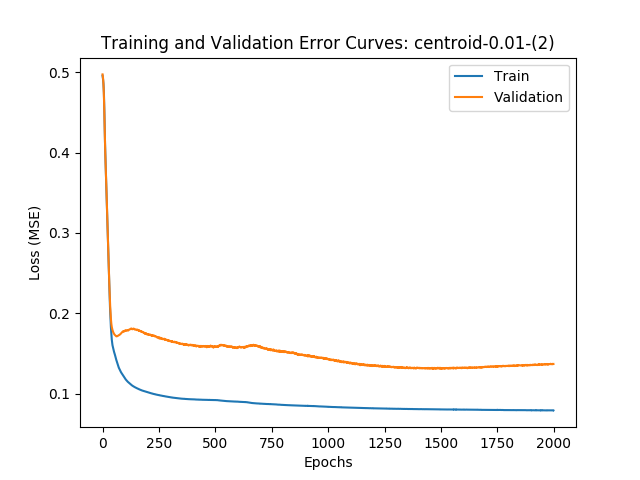

<IPython.core.display.Javascript object>


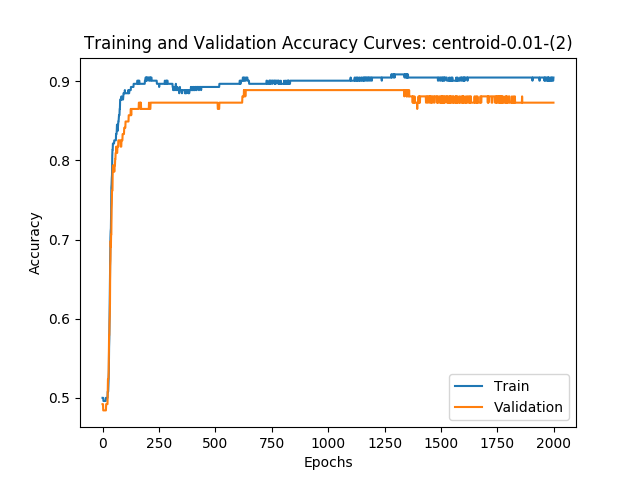

Matriz de confusão
[[1671  227]
 [   8   56]]

Train Loss:       0.0804
Validation Loss:  0.1308
Accuracy:         0.8802
MSE:              0.1198
AUROC:            0.9279


In [43]:
plot_training_error_curves(history, "centroid-0.01-(2)")
plot_training_acc_curves(history, "centroid-0.01-(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [44]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4590 - acc: 0.4563 - val_loss: 0.5013 - val_acc: 0.4762
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4406 - acc: 0.4563 - val_loss: 0.4822 - val_acc: 0.4841
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4232 - acc: 0.4563 - val_loss: 0.4639 - val_acc: 0.4841
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4060 - acc: 0.4643 - val_loss: 0.4435 - val_acc: 0.4841
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3900 - acc: 0.4722 - val_loss: 0.4242 - val_acc: 0.4921
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3735 - acc: 0.4722 - val_loss: 0.4048 - val_acc: 0.5079
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3557 - acc: 0.4881 - val_loss: 0.3862 - val_acc: 0.5079
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.3372 - acc

252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8849 - val_loss: 0.1251 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8849 - val_loss: 0.1242 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8849 - val_loss: 0.1239 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1240 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1241 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8849 - val_loss: 0.1238 - val_acc: 0.8730
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8849 - val_loss: 0.1239 - val_acc: 0.8730
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8849 - val_loss: 0.1235 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8929 - val_loss: 0.1158 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1157 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8929 - val_loss: 0.1156 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1155 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1152 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1149 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1147 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1144 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.8968 - val_loss: 0.1106 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.8968 - val_loss: 0.1098 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - ETA: 0s - loss: 0.0701 - acc: 0.968 - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.8968 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.896

252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.8929 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.8968 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1091 - val_acc: 0.8810
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8810
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1181 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8889
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1172 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9087 - val_loss: 0.1168 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1162 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1163 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.1149 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1143 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8968
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9087 - val_loss: 0.1150 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9087 - val_loss: 0.1149 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9127 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9127 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1143 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9087 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9087 - val_loss: 0.1137 - val_acc:

252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1142 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1145 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.1142 - val_acc:

252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1150 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9087 - val_loss: 0.1153 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1155 - val_acc: 0.8730
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8730
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1157 - val_acc: 0.8730
Epoch 1288/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1152 - val_acc:

252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1166 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8730
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.1169 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1162 - val_acc: 0.8730
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8730
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1167 - val_acc:

252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1172 - val_acc: 0.8730
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8730
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1183 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1176 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1175 - val_acc: 0.8730
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1173 - val_acc:

252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.1187 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8571
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.1186 - val_acc: 0.8651
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9048 - val_loss: 0.1189 - val_acc: 0.8651
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.1185 - val_acc:

252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1195 - val_acc: 0.8571
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1208 - val_acc: 0.8571
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1203 - val_acc: 0.8571
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9048 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1194 - val_acc:

252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1210 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1215 - val_acc: 0.8571
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1215 - val_acc: 0.8571
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1213 - val_acc: 0.8571
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1214 - val_acc:

In [45]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096186774312903026, 0.89551478071436363]


<IPython.core.display.Javascript object>


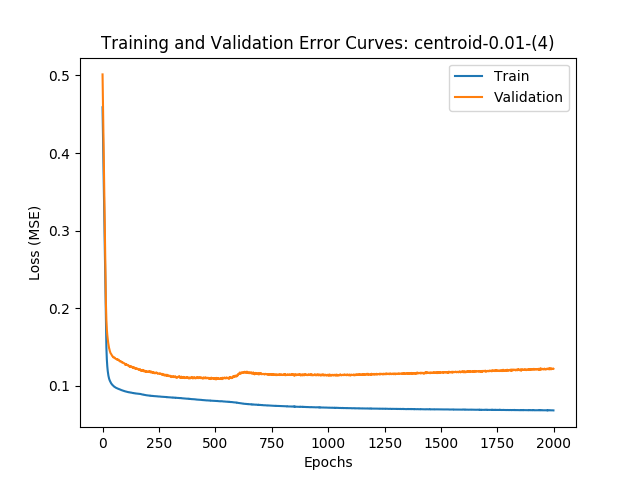

<IPython.core.display.Javascript object>


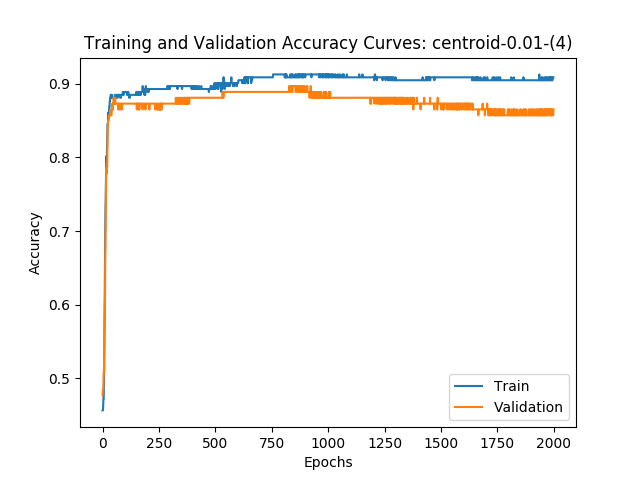

Matriz de confusão
[[1702  196]
 [   9   55]]

Train Loss:       0.0806
Validation Loss:  0.1082
Accuracy:         0.8955
MSE:              0.1045
AUROC:            0.9385


In [46]:
plot_training_error_curves(history, "centroid-0.01-(4)")
plot_training_acc_curves(history, "centroid-0.01-(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))